# Model Training & Experiment Tracking
## Heart Disease Prediction – MLOps Assignment

**Objective:**  
Train multiple classification models, compare performance, and track experiments using MLflow.


# Installing required libraries

In [9]:
%pip install mlflow
%pip install databricks-sdk --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Restarting the kernel

# Import required libraries

In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report
)

import mlflow
import mlflow.sklearn

import matplotlib.pyplot as plt
import seaborn as sns


# Load cleaned dataset

In [11]:
data_path = "/Users/rakeshjha/Assignment/MLops/Heart_Analysis/Group_125_MLops_Assignment_1/data/processed/heart_clean.csv"
df = pd.read_csv(data_path)

X = df.drop("target", axis=1)
y = df["target"]

df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# Train-Test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# Preprocessing pipeline

In [13]:
numeric_features = X.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ]
)


# Define Models

In [14]:
models = {
    "Logistic_Regression": LogisticRegression(
        max_iter=1000,
        random_state=42
    ),
    "Random_Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    )
}


# Configure MLflow

In [15]:
mlflow.set_experiment("/Shared/Heart_Disease")

2026/01/02 20:13:58 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/02 20:13:58 INFO mlflow.store.db.utils: Updating database tables
2026/01/02 20:13:58 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/02 20:13:58 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/02 20:13:58 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/02 20:13:58 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/02 20:13:58 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/02 20:13:58 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/02 20:13:58 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/02 20:13:58 INFO alembic.runtime.migration: Running 

<Experiment: artifact_location='/Users/rakeshjha/Assignment/MLops/Heart_Analysis/Group_125_MLops_Assignment_1/notebooks/mlruns/1', creation_time=1767365038721, experiment_id='1', last_update_time=1767365038721, lifecycle_stage='active', name='/Shared/Heart_Disease', tags={}>

# Train models and log experiment

In [16]:
results = []

for model_name, model in models.items():

    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    with mlflow.start_run(run_name=model_name):
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)

        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("roc_auc", roc_auc)

        mlflow.sklearn.log_model(pipeline, "model")

        results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "ROC-AUC": roc_auc
        })

        print(f"\n{model_name} Results")
        print(classification_report(y_test, y_pred))


2026/01/02 20:13:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/02 20:14:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Logistic_Regression Results
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60


Random_Forest Results
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.83      0.71      0.77        28

    accuracy                           0.80        60
   macro avg       0.81      0.79      0.80        60
weighted avg       0.80      0.80      0.80        60



# Feature Importance Plots (Random Forest)

In [17]:
# Retrieve the trained Random Forest model from MLflow run
rf_pipeline = None

for model_name, model in models.items():
    if model_name == "Random_Forest":
        rf_pipeline = Pipeline(steps=[
            ("preprocessing", preprocessor),
            ("classifier", model)
        ])
        rf_pipeline.fit(X_train, y_train)

# Extract feature importances
rf_model = rf_pipeline.named_steps["classifier"]
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df


,Feature,Importance
12,thal,0.150301
2,cp,0.147398
7,thalach,0.114181
9,oldpeak,0.107581
11,ca,0.100354
0,age,0.082761
3,trestbps,0.070465
4,chol,0.069812
10,slope,0.053229
8,exang,0.049348


## Feature importance plot

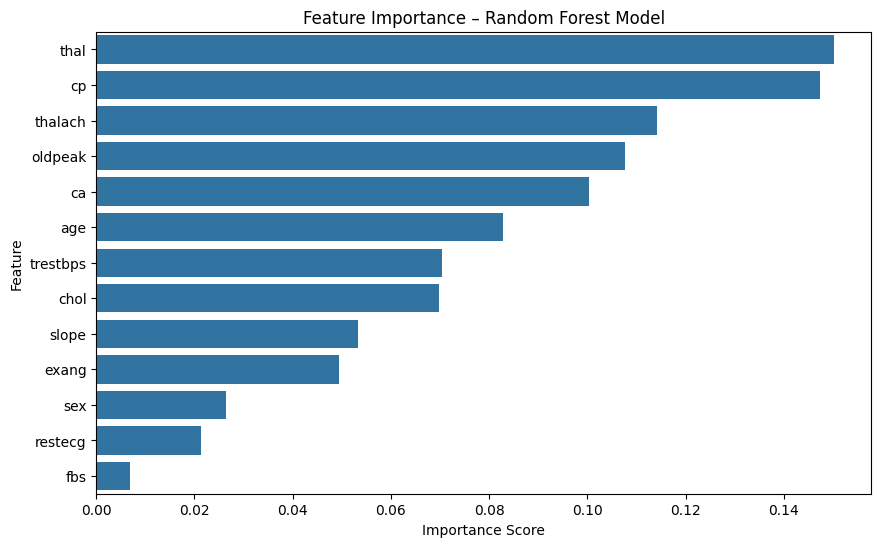

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df
)
plt.title("Feature Importance – Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


# Compare model performance

In [19]:
results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,ROC-AUC
0,Logistic_Regression,0.833333,0.846154,0.785714,0.949777
1,Random_Forest,0.800000,0.833333,0.714286,0.936384


# Visual comparison of ROC-AUC

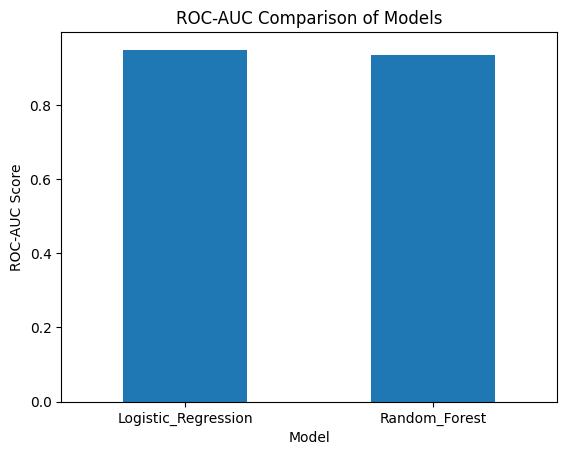

In [20]:

results_df.set_index("Model")["ROC-AUC"].plot(kind="bar")
plt.title("ROC-AUC Comparison of Models")
plt.ylabel("ROC-AUC Score")
plt.xticks(rotation=0)
plt.show()


# Grid Search for Random Forest

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [4, 6, 8],
    "classifier__min_samples_split": [2, 5]
}

rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)

print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")


Best Parameters:
{'classifier__max_depth': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV ROC-AUC: 0.9020


## Evaluate Tuned Model

In [22]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.78      0.91      0.84        32
           1       0.87      0.71      0.78        28

    accuracy                           0.82        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.82      0.82      0.81        60

Test ROC-AUC: 0.9464285714285714


## Log Tuned Model to MLflow

In [23]:
with mlflow.start_run(run_name="Random_Forest_Tuned"):
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_prob))
    mlflow.sklearn.log_model(best_model, "model")


2026/01/02 20:14:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


# Cross validation

In [24]:
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    cv_score = cross_val_score(
        pipeline,
        X,
        y,
        cv=5,
        scoring="roc_auc"
    ).mean()

    print(f"{model_name} CV ROC-AUC: {cv_score:.4f}")


Logistic_Regression CV ROC-AUC: 0.9026
Random_Forest CV ROC-AUC: 0.9050


# Model selection summary

## Model Selection Summary

- Logistic Regression served as a strong baseline model.
- Random Forest consistently achieved higher ROC-AUC, Precision, and Recall.
- Random Forest was selected for deployment due to its superior performance and ability to capture non-linear relationships.


# Register Best Model

In [25]:
# Register best model manually from MLflow UI as Production
print("Register the best model in MLflow Model Registry as 'Production'")


Register the best model in MLflow Model Registry as 'Production'
